In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_curve, average_precision_score,
    roc_curve
)
from sklearn.calibration import CalibratedClassifierCV

# Opcional: imbalanced-learn para SMOTE
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, average_precision_score



In [14]:
df = pd.read_parquet('df_tratado.parquet')

In [3]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2,3040.0,0.057356,2
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1,1300.0,0.024375,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0,3042.0,0.028371,2
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0,3300.0,0.006008,0
6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1,1750.0,0.093902,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,1.000000,22,0,0.000000,820.0,1,0,0,0,0,820.0,0.000000,0
149995,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0,3400.0,0.050537,0
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0,2100.0,0.045026,0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0,5716.0,0.000000,0


In [13]:
# Verificar proporção de classes
print('Distribuição da variável alvo:')
print(df['SeriousDlqin2yrs'].value_counts())
print('Proporção de positivos (1):', df['SeriousDlqin2yrs'].mean())

Distribuição da variável alvo:
SeriousDlqin2yrs
0    96238
1     6967
Name: count, dtype: int64
Proporção de positivos (1): 0.06750641926263262


In [15]:
df.drop(columns=['NumberOfTimes90DaysLate','NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse'], inplace=True)

In [5]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total
1,1,0.766127,45,0.802982,9120.0,13,6,2,3040.0,0.057356,2
2,0,0.957151,40,0.121876,2600.0,4,0,1,1300.0,0.024375,0
3,0,0.658180,38,0.085113,3042.0,2,0,0,3042.0,0.028371,2
4,0,0.233810,30,0.036050,3300.0,5,0,0,3300.0,0.006008,0
6,0,0.213179,74,0.375607,3500.0,3,1,1,1750.0,0.093902,0
...,...,...,...,...,...,...,...,...,...,...,...
149994,0,1.000000,22,0.000000,820.0,1,0,0,820.0,0.000000,0
149995,0,0.385742,50,0.404293,3400.0,7,0,0,3400.0,0.050537,0
149996,0,0.040674,74,0.225131,2100.0,4,1,0,2100.0,0.045026,0
149999,0,0.000000,30,0.000000,5716.0,4,0,0,5716.0,0.000000,0


In [ ]:
df_proc = df.copy()

# Tratar MonthlyIncome com logaritmo 
df_proc['MonthlyIncome_log'] = np.log1p(df_proc['MonthlyIncome'].clip(lower=0))

# Limitar DebtRatio e DebtPerLoan para reduzir outliers extremos 
df_proc['DebtRatio_clipped'] = df_proc['DebtRatio'].clip(upper=10) 
df_proc['DebtPerLoan_clipped'] = df_proc['DebtPerLoan'].clip(upper=100)  

# Seleção de colunas para o modelo
cols_to_use = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
 'NumberOfDependents', 'IncomePerDependent',
    'Pagamentos_atrasados_Total', 'MonthlyIncome_log', 'DebtRatio_clipped', 'DebtPerLoan_clipped'
]

X = df_proc[cols_to_use]
y = df_proc['SeriousDlqin2yrs']

X.shape

(103205, 10)

In [ ]:
# Divisão treino/teste 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (72243, 10) Test: (30962, 10)


In [18]:
# ===== Sem SMOTE =====
pipe_logreg = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000, solver='saga',
                                 class_weight='balanced', random_state=42))
])

pipe_nb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', GaussianNB())
])

pipe_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=5000, solver='saga',
                                 class_weight='balanced', random_state=42))
])

# ===== Com SMOTE =====
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipe_logreg_smote = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.8)),  # 0.6~1.0: teste
    ('model', LogisticRegression(max_iter=5000, solver='saga',
                                 random_state=42))
])

pipe_poly_smote = ImbPipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
    ('model', LogisticRegression(max_iter=5000, solver='saga',
                                 random_state=42))
])


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score, needs_proba=True)
}

param_logreg = {
    'model__C': [0.01, 0.1, 1, 10]
}

param_poly = {
    'poly__degree': [2],  
    'model__C': [0.01, 0.1, 1, 10]
}

param_logreg_smote = {
    'smote__sampling_strategy': [0.6, 0.8, 1.0],
    'model__C': [0.01, 0.1, 1, 10]
}

param_poly_smote = {
    'poly__degree': [2],
    'smote__sampling_strategy': [0.6, 0.8, 1.0],
    'model__C': [0.01, 0.1, 1, 10]
}

gscv_logreg = GridSearchCV(pipe_logreg, param_logreg, scoring=scoring,
                           cv=cv, n_jobs=-1, refit='pr_auc')
gscv_nb = GridSearchCV(pipe_nb, {'model__var_smoothing': [1e-9, 1e-8, 1e-7]},
                       scoring=scoring, cv=cv, n_jobs=-1, refit='pr_auc')
gscv_poly = GridSearchCV(pipe_poly, param_poly, scoring=scoring,
                         cv=cv, n_jobs=-1, refit='pr_auc')

# Versões com SMOTE 
gscv_logreg_smote = GridSearchCV(pipe_logreg_smote, param_logreg_smote, scoring=scoring,
                                 cv=cv, n_jobs=-1, refit='pr_auc')
gscv_poly_smote = GridSearchCV(pipe_poly_smote, param_poly_smote, scoring=scoring,
                               cv=cv, n_jobs=-1, refit='pr_auc')

USE_SMOTE = True

models_cv = (
    {
        'Logística': gscv_logreg,
        'NaiveBayes': gscv_nb,
        'LogísticaPolinomial': gscv_poly
    } if not USE_SMOTE else
    {
        'Logística+SMOTE': gscv_logreg_smote,
        'NaiveBayes': gscv_nb,                 
        'Polinomial+SMOTE': gscv_poly_smote
    }
)


In [28]:
resultados = []
for nome, gscv in models_cv.items():
    print(f'CV + GridSearch -> {nome}')
    gscv.fit(X_train, y_train)
    print('Best params:', gscv.best_params_,
          '| Best CV ROC-AUC:', gscv.cv_results_['mean_test_roc_auc'][gscv.best_index_],
          '| Best CV PR-AUC:', gscv.cv_results_['mean_test_pr_auc'][gscv.best_index_])
    resultados.append({
        'Modelo': nome,
        'BestParams': gscv.best_params_,
        'CV_ROC_AUC': gscv.cv_results_['mean_test_roc_auc'][gscv.best_index_],
        'CV_PR_AUC': gscv.cv_results_['mean_test_pr_auc'][gscv.best_index_],
    })

resultados_df = pd.DataFrame(resultados)
display(resultados_df)


CV + GridSearch -> Logística+SMOTE
Best params: {'model__C': 0.01, 'smote__sampling_strategy': 1.0} | Best CV ROC-AUC: 0.8432475465803847 | Best CV PR-AUC: 0.34592329755041157
CV + GridSearch -> NaiveBayes
Best params: {'model__var_smoothing': 1e-09} | Best CV ROC-AUC: 0.8203334051200546 | Best CV PR-AUC: 0.32291393254789397
CV + GridSearch -> Polinomial+SMOTE
Best params: {'model__C': 0.01, 'poly__degree': 2, 'smote__sampling_strategy': 0.6} | Best CV ROC-AUC: 0.8471613724692194 | Best CV PR-AUC: 0.3546583770051838


,Modelo,BestParams,CV_ROC_AUC,CV_PR_AUC
0,Logística+SMOTE,"{'model__C': 0.01, 'smote__sampling_strategy':...",0.843248,0.345923
1,NaiveBayes,{'model__var_smoothing': 1e-09},0.820333,0.322914
2,Polinomial+SMOTE,"{'model__C': 0.01, 'poly__degree': 2, 'smote__...",0.847161,0.354658


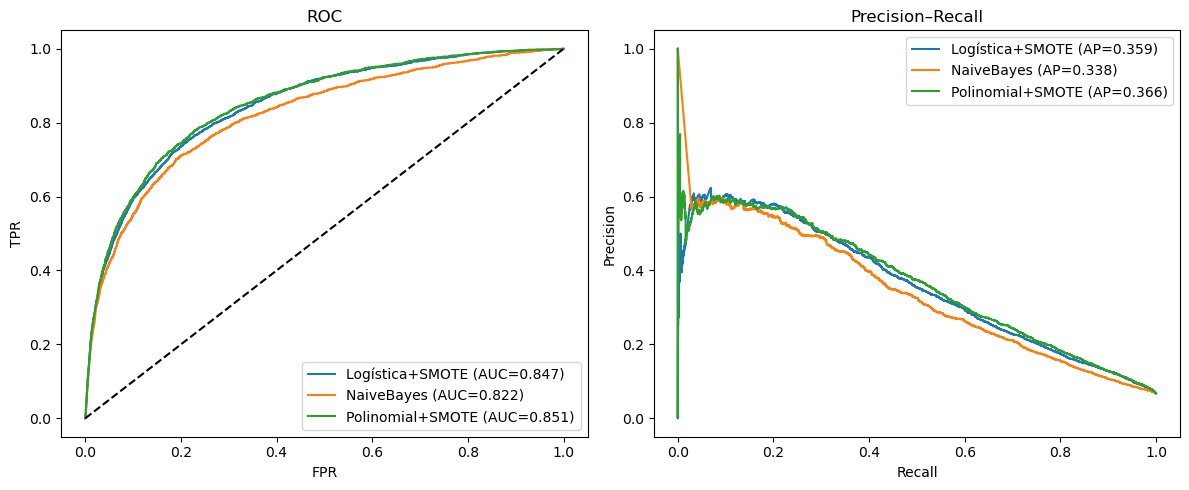

,Modelo,Acurácia,Precisão,Recall,F1,ROC-AUC,PR-AUC
2,Polinomial+SMOTE,0.854079,0.265728,0.658852,0.378713,0.851493,0.365931
0,Logística+SMOTE,0.784768,0.203141,0.748804,0.319583,0.846620,0.358906
1,NaiveBayes,0.933790,0.521739,0.229665,0.318937,0.822199,0.337698


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, roc_curve,
                             precision_recall_curve)

evals = []

plt.figure(figsize=(12,5))
ax_roc = plt.subplot(1,2,1)
ax_pr = plt.subplot(1,2,2)

for nome, gscv in models_cv.items():
    best = gscv.best_estimator_

   
    needs_calibration = ('NaiveBayes' in nome) 
    if needs_calibration and hasattr(best, 'predict_proba'):
        clf = CalibratedClassifierCV(best, cv=3)
        clf.fit(X_train, y_train)
    else:
        clf = best

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1] if hasattr(clf, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    ap = average_precision_score(y_test, y_prob) if y_prob is not None else np.nan

    evals.append({
        'Modelo': nome,
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1': f1,
        'ROC-AUC': roc,
        'PR-AUC': ap
    })

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        ax_roc.plot(fpr, tpr, label=f'{nome} (AUC={roc:.3f})')
        pr, rc, _ = precision_recall_curve(y_test, y_prob)
        ax_pr.plot(rc, pr, label=f'{nome} (AP={ap:.3f})')

ax_roc.plot([0,1],[0,1],'k--'); ax_roc.set_title('ROC'); ax_roc.set_xlabel('FPR'); ax_roc.set_ylabel('TPR'); ax_roc.legend()
ax_pr.set_title('Precision–Recall'); ax_pr.set_xlabel('Recall'); ax_pr.set_ylabel('Precision'); ax_pr.legend()
plt.tight_layout(); plt.show()

evals_df = pd.DataFrame(evals).sort_values('PR-AUC', ascending=False)
display(evals_df)


Melhor modelo: Polinomial+SMOTE

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.87      0.92     28872
           1       0.27      0.66      0.38      2090

    accuracy                           0.85     30962
   macro avg       0.62      0.76      0.65     30962
weighted avg       0.92      0.85      0.88     30962



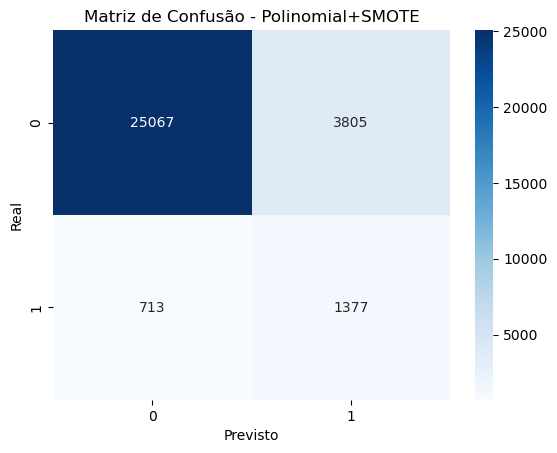

In [30]:
best_name = evals_df.iloc[0]['Modelo']
best_est = models_cv[best_name].best_estimator_

y_pred = best_est.predict(X_test)
print('Melhor modelo:', best_name)
print('\nClassification report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto'); plt.ylabel('Real'); plt.title(f'Matriz de Confusão - {best_name}')
plt.show()
